# The bias-variance trade-off

The errors that an ML model makes when predicting outcomes for new input data can be broken down into reducible and irreducible parts. The irreducible part is due to random variation (noise) in the data that is not measured, such as relevant but missing variables or natural variation. The reducible part of the generalization error, in turn, can be broken down into bias and variance. Both are due to differences between the true functional relationship and the assumptions made by the machine learning algorithm, as detailed in the following list:

- **Error due to bias**: The hypothesis is too simple to capture the complexity of the true functional relationship. As a result, whenever the model attempts to learn the true function, it makes systematic mistakes and, on average, the predictions will be similarly biased. This is also called underfitting.

- **Error due to variance**: The algorithm is overly complex in view of the true relationship. Instead of capturing the true relationship, it overfits to the data and extracts patterns from the noise. As a result, it learns different functional relationships from each sample, and out-of-sample predictions will vary widely.


In [1]:
import pandas as pd
import numpy as np
from numpy.random import randint, choice, normal,shuffle
from scipy.special import factorial
from sklearn.model_selection import learning_curve, TimeSeriesSplit, PredefinedSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rc('figure', figsize=(14, 8))

## Underfitting vs overfitting

The following code illustrates overfitting by approximating a cosine function using increasingly complex polynomials (change `max_degree`) and measuring the in-sample error. 

More specifically, we draw 10 random samples with some added noise (n = 30) to learn a polynomial of varying complexity (see the code in the accompanying notebook). Each time, the model predicts new data points and we capture the mean-squared error for these predictions, as well as the standard deviation of these errors.

The figure in the book shows the results for a polynomial of degree 1, which yields a straight line clearly underfits the true function. However, the estimated line will not differ dramatically from one sample drawn from the true function to the next. 

The middle panel shows that a degree 5 polynomial approximates the true relationship reasonably well on the [0, 1] interval. On the other hand, a polynomial of degree 15 fits the small sample almost perfectly, but provides a poor estimate of the true relationship: it overfits to the random variation in the sample data points, and the learned function will vary strongly with each sample drawn.

### Generate Sample Data

In [3]:
max_degree = 10
def f(x):
    taylor = [(-1)**i * x ** e / factorial(e) for i, e in enumerate(range(1, max_degree, 2))]
    return  np.sum(taylor, axis=0)

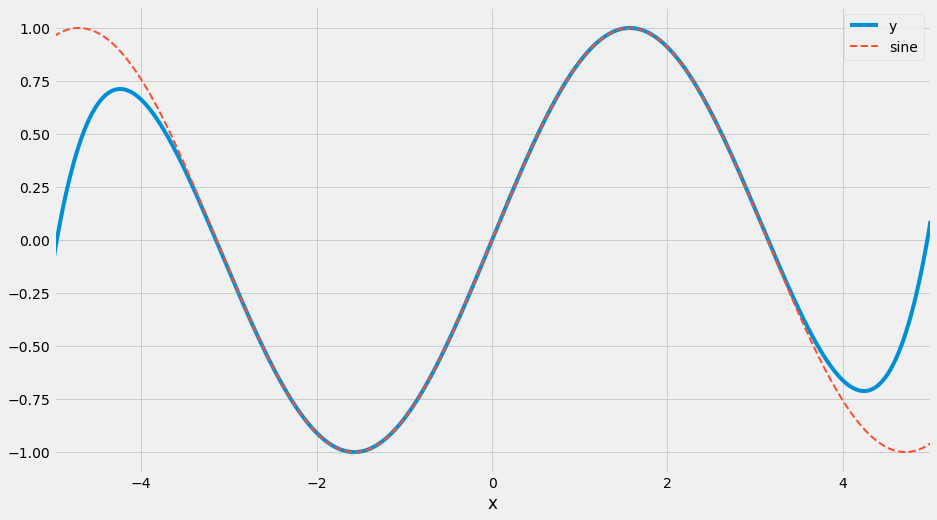

In [4]:
x = np.linspace(-5, 5, 1000)
data = pd.DataFrame({'y': f(x), 'x': x})
ax = data.plot(x='x', y='y', legend=False)
pd.Series(np.sin(x), index=x).plot(ax=ax, ls='--', lw=2, label='sine')
plt.legend();

## Managing the trade-off

Let's further illustrate the impact of overfitting versus underfitting by trying to learn a Taylor series approximation of the cosine function of ninth degree with some added noise. In the following diagram, we draw random samples of the true function and fit polynomials that underfit, overfit, and provide an approximately correct degree of flexibility. We then predict out-of-sample and measure the RMSE. 

The high bias but low variance of a polynomial of degree 3 compares to the low bias but exceedingly high variance of the various prediction errors visible in the first panel. The left-hand panel shows the distribution of the errors that result from subtracting the true function values. The underfit case of a straight line produces a poor in-sample fit and is significantly off target out of sample. The overfit model shows the best fit in-sample with the smallest dispersion of errors, but the price is a large variance out-of-sample. The appropriate model that matches the functional form of the true model performs the best by far out-of-sample. 

### Train Model

In [5]:
X={}
datasets = ['Train', 'Test']
X['Train'] = np.linspace(-3, 3, 2500)
X['Test'] = np.linspace(3, 5, 500)
models = {'Underfit': 3, 'Right Fit': 9, 'Overfit': 15}

sample, noise = 100, .2
result = pd.DataFrame()
for i in range(100):
    x_ = {d: choice(X[d], size=sample, replace=False) for d in datasets}
    y_ = {d: f(x_[d]) for d in datasets}
    y_['Train'] += normal(loc=0,
                          scale=np.std(y_['Train']) * noise,
                          size=sample)

    trained_models = {fit: np.poly1d(np.polyfit(x=x_['Train'],
                                        y=y_['Train'],
                                        deg=deg))
              for fit, deg in models.items()}

    for fit, model in trained_models.items():
        for dataset in datasets:
            pred = model(x_[dataset])
            result = result.append(pd.DataFrame(dict(x=x_[dataset],
                                                     Model=fit,
                                                     Data=dataset,
                                                     y=pred,
                                                     Error=pred - y_[dataset])))

In [6]:
y = {d: f(X[d]) for d in datasets}
y['Train_noise'] = y['Train'] + normal(loc=0,
                                       scale=np.std(y['Train']) * noise,
                                       size=len(y['Train']))
colors = {'Underfit': 'darkblue', 'Right Fit': 'darkgreen', 'Overfit': 'darkred'}
test_data = result[result.Data == 'Test']

### Plot result

The right-hand panel of the following screenshot shows the actual predictions rather than the errors to demonstrate what the different types of fit look like in practice.

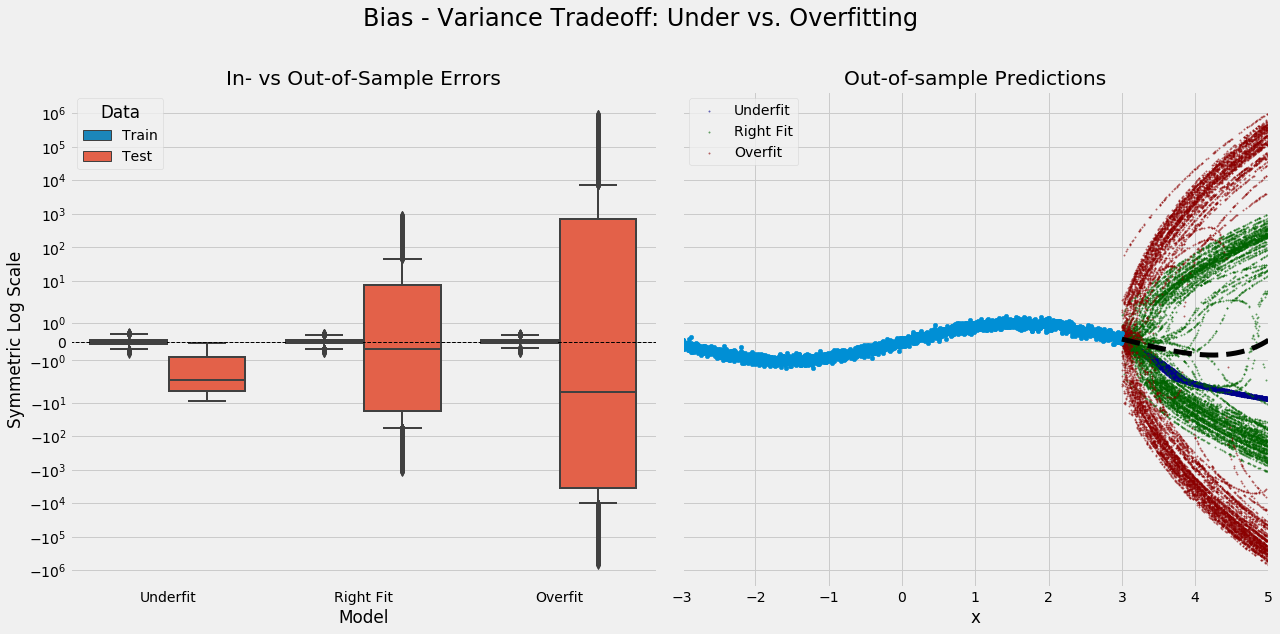

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 9), sharey=True)
sns.boxplot(x='Model', y='Error', hue='Data',
            data=result, ax=axes[0], linewidth=2)
axes[0].set_title('In- vs Out-of-Sample Errors')
axes[0].axhline(0, ls='--', lw=1, color='k')
axes[0].set_ylabel('Symmetric Log Scale')

for model in colors.keys():
    (test_data[(test_data['Model'] == model)]
     .plot.scatter(x='x',
                   y='y',
                   ax=axes[1],
                   s=2,
                   color=colors[model],
                   alpha=.5,
                   label=model))

pd.Series(y['Train'], index=X['Train']).sort_index().plot(
    ax=axes[1], title='Out-of-sample Predictions')
pd.DataFrame(dict(x=X['Train'], y=y['Train_noise'])
             ).plot.scatter(x='x', y='y', ax=axes[1])
pd.Series(y['Test'], index=X['Test']).plot(
    color='black', lw=5, ls='--', ax=axes[1], label='Actuals')
plt.yscale('symlog')

fig.tight_layout()
fig.suptitle('Bias - Variance Tradeoff: Under vs. Overfitting', fontsize=24)
fig.savefig('bias_variance', dpi=600)
fig.subplots_adjust(top=0.85)

In [8]:
def folds(train, test, nfolds):
    shuffle(train)
    shuffle(test)
    
    steps = (np.array([len(train), len(test)]) / nfolds).astype(int)
    for fold in range(nfolds):
        i, j = fold * steps
        yield train[i:i + steps[0]], test[j: j+steps[1]]

In [9]:
def rmse(y, x, model):
    return np.sqrt(mean_squared_error(y_true=y, y_pred=model.predict(x)))

In [10]:
def create_poly_data(data, degree):
    return np.hstack((data.reshape(-1, 1) ** i) for i in range(degree + 1))

In [11]:
train_set = X['Train'] + normal(scale=np.std(f(X['Train']))) * .2
test_set =  X['Test'].copy()  

sample_sizes = np.arange(.1, 1.0, .01)
indices = ([len(train_set), len(test_set)] *
           sample_sizes.reshape(-1, 1)).astype(int)
result = []
lr = LinearRegression()
for label, degree in models.items():
    model_train = create_poly_data(train_set, degree)
    model_test = create_poly_data(test_set, degree)
    for train_idx, test_idx in indices:
        train = model_train[:train_idx]
        test = model_test[:test_idx]
        train_rmse, test_rmse = [], []
        for x_train, x_test in folds(train, test, 5):
            y_train, y_test = f(x_train[:, 1]), f(x_test[:, 1])
            lr.fit(X=x_train, y=y_train)
            train_rmse.append(rmse(y=y_train, x=x_train, model=lr))
            test_rmse.append(rmse(y=y_test, x=x_test, model=lr))
        result.append([label, train_idx,
                       np.mean(train_rmse), np.std(train_rmse),
                       np.mean(test_rmse), np.std(test_rmse)])

result = (pd.DataFrame(result,
                       columns=['Model', 'Train Size',
                                'Train RMSE', 'Train RMSE STD',
                                'Test RMSE', 'Test RMSE STD'])
          .set_index(['Model', 'Train Size']))

A learning curve plots the evolution of train and test errors against the size of the dataset used to learn the functional relationship. It is a useful tool to diagnose the bias-variance trade-off for a given model because the errors will behave differently. A model with a high bias will have a high but similar training error, both in-sample and out-of-sample, whereas an overfit model will have a very low training error.

The declining out-of-sample error illustrates that overfit models may benefit from additional data or tools to limit the model's complexity, such as regularization, whereas underfit models need to use either more features or otherwise increase the complexity of the model, as shown in the following screenshot.

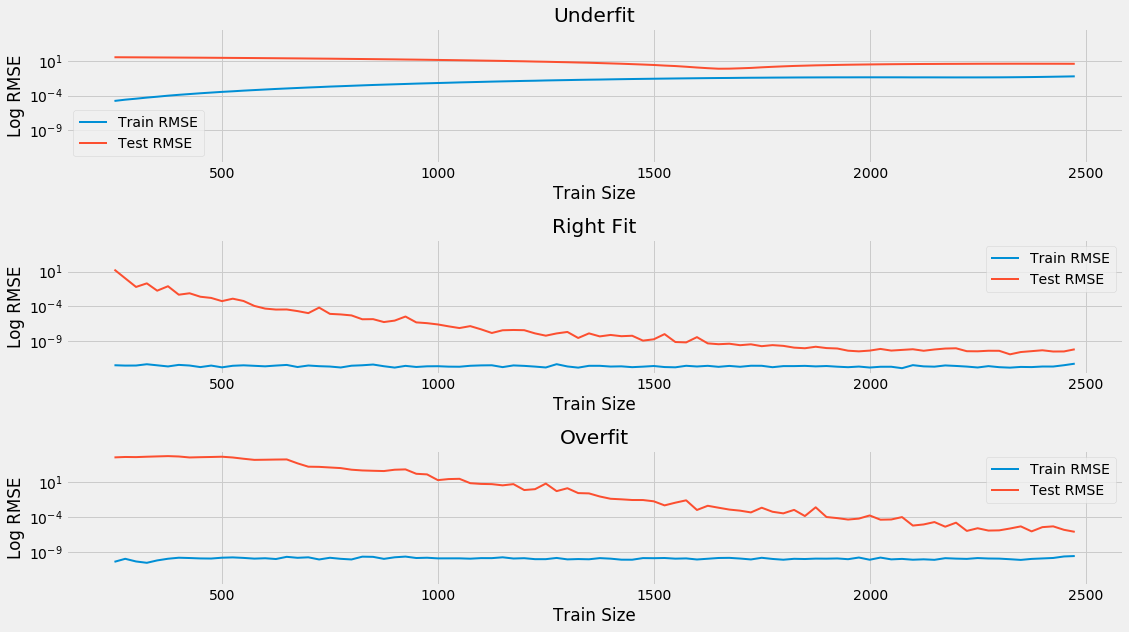

In [12]:
fig, axes = plt.subplots(nrows=3, sharey=True, figsize=(16, 9))
for i, model in enumerate(models.keys()):
    result.loc[model, ['Train RMSE', 'Test RMSE']].plot(ax=axes[i], title=model, logy=True, lw=2)
    axes[i].set_ylabel('Log RMSE')
plt.tight_layout();

In [13]:
train_set = X['Train'] + normal(scale=np.std(f(X['Train']))) * .2
test_set = X['Test'].copy()

sample_sizes = np.arange(.1, 1.0, .01)
indices = ([len(train_set), len(test_set)] *
           sample_sizes.reshape(-1, 1)).astype(int)
result = pd.DataFrame()
lr = LinearRegression()
for label, degree in models.items():
    model_train = create_poly_data(train_set, degree)
    model_test = create_poly_data(test_set, degree)
    for train_idx, test_idx in indices:
        train = model_train[:train_idx]
        test = model_test[:test_idx]
        train_rmse, test_rmse = [], []
        for x_train, x_test in folds(train, test, 10):
            y_train, y_test = f(x_train[:, 1]), f(x_test[:, 1])
            lr.fit(X=x_train, y=y_train)
            train_rmse.append(rmse(y=y_train, x=x_train, model=lr))
            test_rmse.append(rmse(y=y_test, x=x_test, model=lr))
        result = (result
                  .append(pd.DataFrame({'Model': label,
                                        'Train Size': train_idx,
                                        'Data': 'Train',
                                        'RMSE': train_rmse}))
                  .append(pd.DataFrame({'Model': label,
                                        'Train Size': train_idx,
                                        'Data': 'Test',
                                        'RMSE': test_rmse})))

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


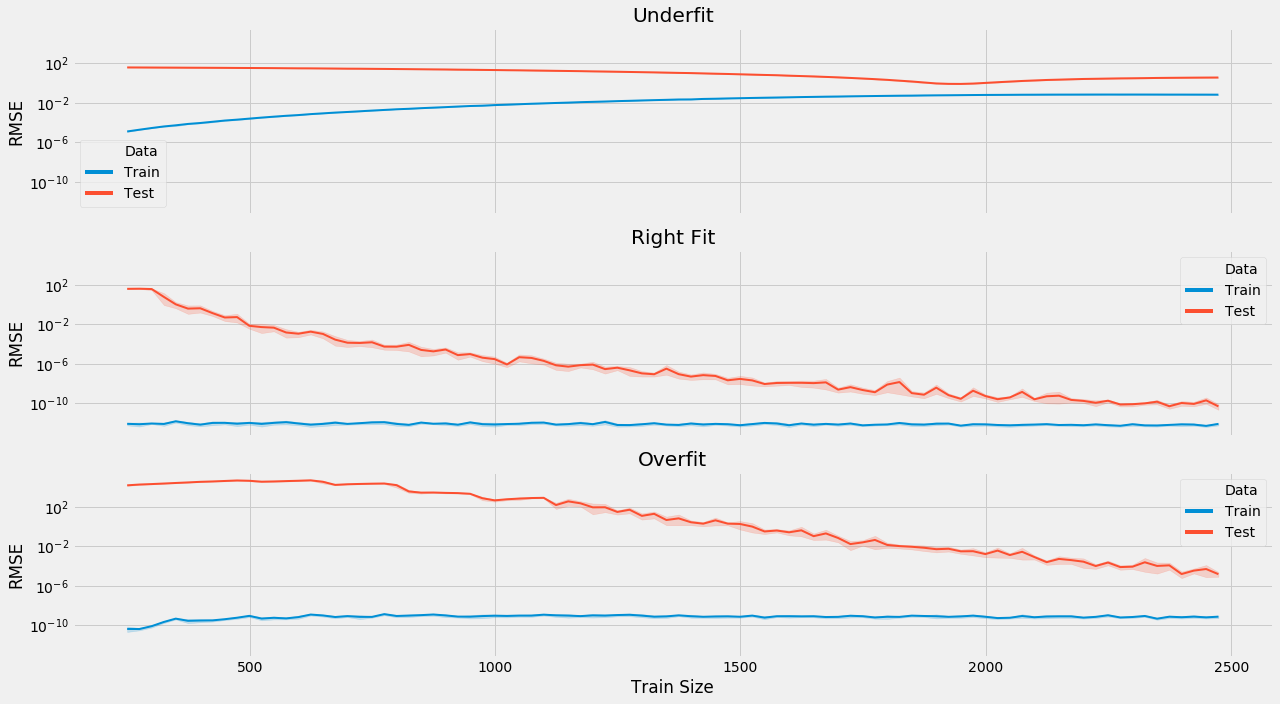

In [14]:
fig, axes = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(18, 10))
for i, model in enumerate(models.keys()):
    sns.lineplot(x='Train Size', y='RMSE', hue='Data', data=result[result.Model==model], ax=axes[i], lw=2)
    axes[i].set_title(model)
plt.yscale('log')
plt.tight_layout();